In [1]:
import sys

sys.path.append("../..")

In [2]:
%load_ext autoreload

In [3]:
import logging
from argparse import Namespace

import torch
import matplotlib.pyplot as plt

from emgrep.datasets.EMGRepDataloader import get_dataloader
from emgrep.datasets.RepresentationsDataset import RepresentationDataset
from emgrep.models.cpc_model import CPCModel, CPCEncoder, CPCAR

# from emgrep.train_classifier import train_classifier
from emgrep.train_classifier import train_classifier

In [4]:
DEVICE = "cpu"

SUBJECTS = 10
DAYS = 5
TIMES = 2

POS_MODE = "none"

ENC_DIM = 256
AR_DIM = 256
AR_LAYERS = 2

args = {
    "data": "../../data/01_raw",
    "device": DEVICE,
    "output_dir": "logs",
    "n_subjects": SUBJECTS,
    "n_days": DAYS,
    "n_times": TIMES,
    "positive_mode": POS_MODE,
    "val_idx": 1,
    "test_idx": 2,
    "seq_len": 3000,
    "seq_stride": 3000,
    "block_len": 300,
    "block_stride": 300,
    "batch_size_cpc": 256,
    "num_workers": 0,
    "encoder_dim": ENC_DIM,
    "ar_dim": AR_DIM,
    "ar_layers": AR_LAYERS,
    "cpc_k": 5,
    "epochs_cpc": 1,
    "lr_cpc": 0.0002,
    "weight_decay_cpc": 0.0,
    "epochs_classifier": 50,
    "lr_classifier": 0.1,
    "batch_size_classifier": 256,
    "split_mode": "day",
    "debug": True,
    "log_dir": "../../logs/none_1_2/2023-05-03_13-15-11",
    "log_to_file": False,
    "wandb": False,
}

logging.basicConfig(
    level=logging.DEBUG,
    format="%(asctime)s %(levelname)s %(message)s",
)
logging.getLogger("matplotlib").setLevel(logging.WARNING)

args = Namespace(**args)

In [5]:
checkpoint = "../../logs/logs/none_1_2/2023-05-02_23-05-45/checkpoints/best_model.pt"

enc = CPCEncoder(16, args.encoder_dim)
ar = CPCAR(args.encoder_dim, args.ar_dim, args.ar_layers)

model = CPCModel(enc, ar)

model.load_state_dict(torch.load(checkpoint, map_location=args.device))

<All keys matched successfully>

In [6]:
rep_dataloader = get_dataloader(args, extract_rep_mode=True)
representations = {
    "train": RepresentationDataset(model=model, dataloader=rep_dataloader["train"], args=args),
    "val": RepresentationDataset(model=model, dataloader=rep_dataloader["val"], args=args),
    "test": RepresentationDataset(model=model, dataloader=rep_dataloader["test"], args=args),
}
del rep_dataloader

2023-05-07 15:26:13,415 INFO Loading train dataset...
Loading train dataset: 100%|████████████████████████████████████████| 60/60 [01:25<00:00,  1.42s/it]
2023-05-07 15:28:35,689 INFO Loading val dataset...
Loading val dataset: 100%|██████████████████████████████████████████| 20/20 [00:29<00:00,  1.46s/it]
2023-05-07 15:29:12,839 INFO Loading test dataset...
Loading test dataset: 100%|█████████████████████████████████████████| 20/20 [00:27<00:00,  1.39s/it]
2023-05-07 15:29:51,626 INFO Train samples: 285241
2023-05-07 15:29:51,628 INFO Val   samples: 95070
2023-05-07 15:29:51,628 INFO Test  samples: 90947
Generating Embeddings: 100%|████████████████████████████████████| 1115/1115 [25:46<00:00,  1.39s/it]
2023-05-07 15:55:44,742 DEBUG Data shape:   torch.Size([285241, 10, 256])
2023-05-07 15:55:44,744 DEBUG Labels shape: torch.Size([285241, 10])
2023-05-07 15:55:44,767 DEBUG Mapping labels [0, 1, 3, 4, 6, 9, 10, 11] to [0, 1, 2, 3, 4, 5, 6, 7]
Generating Embeddings: 100%|███████████████

In [7]:
sample = representations["train"][0]
print(sample[0])

tensor([[-5.7853e-04, -5.0903e-02, -4.0867e-01,  ...,  2.0720e-01,
          2.0062e-02,  8.4862e-03],
        [ 2.2257e-01, -5.5519e-02, -7.1703e-01,  ...,  4.5675e-01,
         -2.4615e-01,  1.8264e-02],
        [ 3.7971e-01, -6.7555e-02, -7.9537e-01,  ...,  5.4953e-01,
         -3.9767e-01,  6.7015e-03],
        ...,
        [ 4.5252e-01, -9.3459e-02, -8.8973e-01,  ...,  2.4982e-01,
         -8.1577e-01, -1.2007e-02],
        [ 6.6638e-01, -1.0818e-01, -8.9800e-01,  ...,  1.2051e-02,
         -8.2305e-01,  3.5232e-02],
        [ 4.4168e-01, -1.0464e-01, -9.0605e-01,  ...,  2.8401e-01,
         -8.5352e-01, -2.7272e-03]])


In [8]:
from emgrep.train_classifier import train_classifier

In [9]:
metrics = train_classifier(representations, pred_block=-1, args=args)

logging.info(f"Train accuracy: {metrics['train']['accuracy']:.3f}")
logging.info(f"Val accuracy:   {metrics['val']['accuracy']:.3f}")
logging.info(f"Test accuracy:  {metrics['test']['accuracy']:.3f}")

2023-05-07 16:10:19,038 INFO Training the classifier...
2023-05-07 16:10:19,039 DEBUG Number of classes: 8
Training classifier: 100%|██████████| 50/50 [04:26<00:00,  5.32s/it, train loss=1.96, val loss=1.96]
2023-05-07 16:14:48,918 INFO Train classification report:
              precision    recall  f1-score   support

           0       0.36      0.97      0.52     81973
           1       0.18      0.40      0.25     29337
           3       0.00      0.00      0.00     29439
           4       0.00      0.00      0.00     28954
           6       0.00      0.00      0.00     29132
           9       0.00      0.00      0.00     28784
          10       0.00      0.00      0.00     28234
          11       0.00      0.00      0.00     29388

    accuracy                           0.32    285241
   macro avg       0.07      0.17      0.10    285241
weighted avg       0.12      0.32      0.18    285241

2023-05-07 16:14:49,231 INFO Train confusion matrix:
[[79314  2659     0     0     

In [10]:
metrics = {
    "train": [],
    "val": [],
    "test": []
}

for pred_block in range(1, 11):
    m = train_classifier(representations, pred_block=-pred_block, args=args)

    metrics["train"].append(m["train"]["accuracy"])
    metrics["val"].append(m["val"]["accuracy"])
    metrics["test"].append(m["test"]["accuracy"])

2023-05-07 16:14:51,013 INFO Training the classifier...
2023-05-07 16:14:51,013 DEBUG Number of classes: 8
Training classifier: 100%|██████████| 50/50 [04:11<00:00,  5.03s/it, train loss=1.99, val loss=1.98]
2023-05-07 16:19:06,027 INFO Train classification report:
              precision    recall  f1-score   support

           0       0.29      1.00      0.45     81973
           1       0.00      0.00      0.00     29337
           3       0.00      0.00      0.00     29439
           4       0.00      0.00      0.00     28954
           6       0.00      0.00      0.00     29132
           9       0.00      0.00      0.00     28784
          10       0.00      0.00      0.00     28234
          11       0.00      0.00      0.00     29388

    accuracy                           0.29    285241
   macro avg       0.04      0.12      0.06    285241
weighted avg       0.08      0.29      0.13    285241

2023-05-07 16:19:06,279 INFO Train confusion matrix:
[[81973     0     0     0     

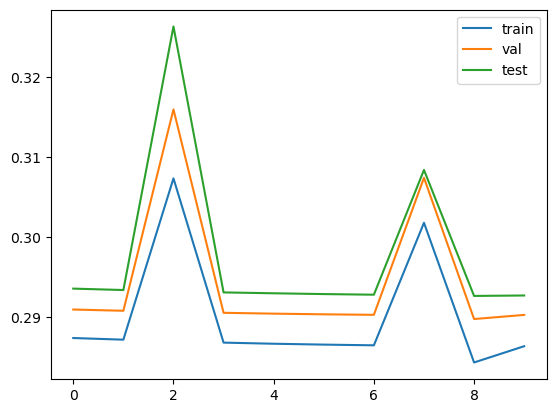

In [11]:
plt.plot(metrics["train"], label="train")
plt.plot(metrics["val"], label="val")
plt.plot(metrics["test"], label="test")

plt.legend()
plt.show()